# Twitter Bot Detector
In this notebook, we are using a dataset from [Kaggle](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts) and [Botometer](https://botometer.osome.iu.edu/bot-repository/datasets.html), containing in total ... twitter user ids. Thanks to the Tweepy Python library we are retrieving users' information, which we considered useful in order to determine the type of an account.We have numerical (followers,friends,listed,statuses,retweets,urls,mentions,age of the account), categorical (geo enabled,verified,has extended profile, has default profile,has default profile image) and also textual (description,tweets) features. So we decided to train 3 models, one for the numerical/categorical features, another for the textual features and one more for the combination of the two types of features.
We also used different classifiers and different evaluation metrics, in order to make comparisons between the results.

## Install Dependencies

In [0]:
!sudo pip install --upgrade pip
!sudo pip install pyspark --upgrade
!pip install nltk
!pip install stopwords
!pip install mlflow

Requirement already satisfied: pip in /usr/local/lib/python3.8/site-packages (21.1.1)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: pyspark in /usr/local/lib/python3.8/site-packages (3.1.1)
Requirement already satisfied: py4j==0.10.9 in /usr/local/lib/python3.8/site-packages (from pyspark) (0.10.9)
 WARNING: Running pip as root will break packages and permissions. You should install packages reliably by using venv: https://pip.pypa.io/warnings/venv 
Requirement already satisfied: nltk in /databricks/python3/lib/python3.8/site-packages (3.6.2)
Requirement already satisfied: click in /databricks/python3/lib/python3.8/site-packages (from nltk) (8.0.0)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk) (0.17.0)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from nltk) (4.60.0)
Requirement already satisfied: regex in /databricks/python3/lib/python3.8/site-packages (from nltk) (2021.4.4)
 WARNING: You are using pip version 20.2.4; however, version 21.1.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: stopwords in /databricks/python3/lib/python3.8/site-packages (1.0.0)
 WARNING: You are using pip version 20.2.4; however, version 21.1.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.17.0)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.0)
Requirement already satisfied: pyyaml in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.17)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.15)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.14.3)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: alembic<=1.4.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.0)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.0)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.2)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.0)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5

## Import Python Packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.session import SparkSession
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer, Tokenizer
from pyspark.sql.functions import udf, col, lower, trim, regexp_replace

import datetime
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import re
now = datetime.datetime.now()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  
porter = PorterStemmer()
RANDOM_SEED = 42 # for reproducibility

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

## Check everything is ok

In [0]:
spark
sc._conf.getAll()

Out[5]: [('spark.files.useFetchCache', 'false'),
 ('spark.databricks.preemption.enabled', 'true'),
 ('spark.driver.tempDirectory', '/local_disk0/tmp'),
 ('spark.hadoop.fs.adl.impl.disable.cache', 'true'),
 ('spark.hadoop.parquet.block.size.row.check.max', '10'),
 ('spark.hadoop.fs.s3a.connection.maximum', '200'),
 ('spark.databricks.clusterUsageTags.numPerClusterInitScriptsV2', '0'),
 ('spark.executor.extraJavaOptions',
 '-Djava.io.tmpdir=/local_disk0/tmp -XX:ReservedCodeCacheSize=512m -XX:+UseCodeCacheFlushing -Djava.security.properties=/databricks/spark/dbconf/java/extra.security -XX:-UseContainerSupport -XX:+PrintFlagsFinal -XX:+PrintGCDateStamps -verbose:gc -XX:+PrintGCDetails -Xss4m -Djava.library.path=/usr/java/packages/lib/amd64:/usr/lib64:/lib64:/lib:/usr/lib:/usr/lib/x86_64-linux-gnu/jni:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/usr/lib/jni -Djavax.xml.datatype.DatatypeFactory=com.sun.org.apache.xerces.internal.jaxp.datatype.DatatypeFactoryImpl -Djavax.xml.parsers.DocumentBuilderFactory=com.sun.org.apache.xerces.internal.jaxp.DocumentBuilderFactoryImpl -Djavax.xml.parsers.SAXParserFactory=com.sun.org.apache.xerces.internal.jaxp.SAXParserFactoryImpl -Djavax.xml.validation.SchemaFactory:http://www.w3.org/2001/XMLSchema=com.sun.org.apache.xerces.internal.jaxp.validation.XMLSchemaFactory -Dorg.xml.sax.driver=com.sun.org.apache.xerces.internal.parsers.SAXParser -Dorg.w3c.dom.DOMImplementationSourceList=com.sun.org.apache.xerces.internal.dom.DOMXSImplementationSourceImpl -Djavax.net.ssl.sessionCacheSize=10000 -Dscala.reflect.runtime.disable.typetag.cache=true -Ddatabricks.serviceName=spark-executor-1'),
 ('spark.hadoop.fs.s3a.fast.upload.active.blocks', '32'),
 ('spark.shuffle.reduceLocality.enabled', 'false'),
 ('spark.sql.streaming.checkpointFileManagerClass',
 'com.databricks.spark.sql.streaming.DatabricksCheckpointFileManager'),
 ('spark.databricks.service.dbutils.repl.backend',
 'com.databricks.dbconnect.ReplDBUtils'),
 ('spark.databricks.clusterUsageTags.driverNodeType', 'dev-tier-node'),
 ('spark.hadoop.spark.sql.sources.outputCommitterClass',
 'com.databricks.backend.daemon.data.client.MapReduceDirectOutputCommitter'),
 ('spark.hadoop.fs.AbstractFileSystem.gs.impl',
 'shaded.databricks.V2_1_4.com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS'),
 ('spark.databricks.clusterUsageTags.instanceBootstrapType', 'ssh'),
 ('spark.streaming.driver.writeAheadLog.allowBatching', 'true'),
 ('spark.databricks.clusterSource', 'UI'),
 ('spark.hadoop.hive.server2.transport.mode', 'http'),
 ('spark.hadoop.hive.server2.thrift.http.cookie.auth.enabled', 'false'),
 ('spark.executor.memory', '8278m'),
 ('spark.databricks.driverNodeTypeId', 'dev-tier-node'),
 ('spark.sql.parquet.compression.codec', 'snappy'),
 ('spark.hadoop.fs.cpfs-adl.impl.disable.cache', 'true'),
 ('spark.databricks.clusterUsageTags.hailEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.clusterLogDeliveryEnabled', 'false'),
 ('spark.databricks.clusterUsageTags.containerType', 'LXC'),
 ('spark.eventLog.enabled', 'false'),
 ('spark.databricks.clusterUsageTags.isIMv2Enabled', 'false'),
 ('spark.databricks.cloudfetch.hasRegionSupport', 'true'),
 ('spark.hadoop.databricks.s3.create.deleteUnnecessaryFakeDirectories',
 'false'),
 ('spark.hadoop.fs.wasb.impl',
 'shaded.databricks.org.apache.hadoop.fs.azure.NativeAzureFileSystem'),
 ('spark.executor.tempDirectory', '/local_disk0/tmp'),
 ('spark.databricks.clusterUsageTags.driverContainerId',
 '84c85a59134c40799d0f8e54f8cb24c6'),
 ('spark.databricks.workerNodeTypeId', 'dev-tier-node'),
 ('spark.hadoop.mapred.output.committer.class',
 'com.databricks.backend.daemon.data.client.DirectOutputCommitter'),
 ('spark.hadoop.hive.server2.thrift.http.port', '10000'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),
 ('spark.sql.allowMultipleContexts', 'false'),
 ('spark.databricks.clusterUsageTags.clusterEbsVolumeSize', '0'),
 ('spark.ui.port', '41148'),
 ('spark.home', '/databricks/spark'),
 ('spark.databr

## Upload Dataset

In [0]:
bot_df = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/tavoulari.1977701@studenti.uniroma1.it/twitter_human_bots_dataset_clean-2.csv", header='true')

## Convert numbers stored as text to numbers

In [0]:
bot_df_text = bot_df

# Drop duplicates
bot_df.dropDuplicates(["id"])

# Subtract profiles' creation dates from current date to convert this field into pure integers
def to_days(then):
  now = datetime.datetime.now()
  date_time_obj = datetime.datetime.strptime(then, '%Y-%m-%d %H:%M:%S').date()
  diff =(now.date() - date_time_obj)
  diff = str(diff).split(' ')
  return int(diff[0])

to_days_UDF = spark.udf.register("to_days",to_days)
bot_df = bot_df.withColumn("created_at", to_days_UDF(col("created_at")))

# Cast numerical features from string to int/float
bot_df = bot_df.selectExpr("account_type","screen_name","cast(follower_count as int) follower_count","cast(friends_count as int) friends_count","cast(listed_count as int) listed_count","cast(statuses_count as int) statuses_count","cast(retweets as float) retweets","cast(with_url as float) with_url","cast(with_mention as float) with_mention","geo_enabled", "verified", "has_extended_profile", "default_profile", "default_profile_image","cast(created_at as int) created_at")

# Textual fields
bot_df_text = bot_df_text.selectExpr("account_type", "screen_name", "description", "tweet_text")
bot_df.printSchema()
bot_df.show(5)


root
-- account_type: string (nullable = true)
-- screen_name: string (nullable = true)
-- follower_count: integer (nullable = true)
-- friends_count: integer (nullable = true)
-- listed_count: integer (nullable = true)
-- statuses_count: integer (nullable = true)
-- retweets: float (nullable = true)
-- with_url: float (nullable = true)
-- with_mention: float (nullable = true)
-- geo_enabled: string (nullable = true)
-- verified: string (nullable = true)
-- has_extended_profile: string (nullable = true)
-- default_profile: string (nullable = true)
-- default_profile_image: string (nullable = true)
-- created_at: integer (nullable = true)

+------------+---------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
account_type| screen_name|follower_count|friends_count|listed_count|statuses_count| retweets| with_url|with_mention|geo_enabled|verified|has_extended_profile|default_profile|default_profile_image|created_at|
+------------+---------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
 bot|best_in_dumbest| 1701| 4| 53| 13123| 0.0| 0.0| 0.0| False| False| False| False| False| 1672|
 human| CJRubinPhoto| 823| 852| 5| 251|0.34108528| 0.33333334| 0.4031008| False| False| True| False| False| 1647|
 human| SVGEGENT| 193| 807| 2| 1204|0.15384616| 0.23846154| 0.3| True| False| False| False| False| 1427|
 human| TinkerVHELPK5| 569| 659| 2| 1651|0.63076925|0.092307694| 0.9692308| True| False| False| True| False| 1758|
 human| JoleonLescott| 748287| 118| 1817| 4292|0.23255815| 0.20930232| 0.8062016| True| True| False| False| False| 3407|
+------------+---------------+--------------+-------------+------------+--------------+----------+-----------+------------+-----------+--------+--------------------+---------------+---------------------+----------+
only showing top 5 rows

## Split features into categories

In [0]:
NUMERICAL_FEATURES = ["follower_count", 
                      "friends_count",
                      "listed_count",
                      "statuses_count",
                      "retweets",
                      "with_url",
                      "with_mention",
                      "created_at"
                      ]
CATEGORICAL_FEATURES = ["geo_enabled", 
                        "verified", 
                        "has_extended_profile",
                        "default_profile",
                        "default_profile_image",
                        ]

TEXTUAL_FEATURES =  ["screen_name",
                     "description",
                     "tweet_text"
                     ]

TARGET_VARIABLE = "account_type"

In [0]:
bot_df.groupBy(TARGET_VARIABLE).count().show()
train_df, test_df = bot_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

+------------+-----+
account_type|count|
+------------+-----+
 human|18935|
 bot| 5260|
+------------+-----+

## Vectorization - Logistic Regression - Tuning Hyperparameters

In [0]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train, 
                                 numerical_features, 
                                 categorical_features, 
                                 target_variable, 
                                 with_std=True,
                                 with_mean=True,
                                 k_fold=5):

    # 1.a Create a list of indexers, i.e., one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # 1.b Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    # 1.c Indexing the target column (i.e., transform human/bot into 0/1) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    # 2.a Create the StandardScaler
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [encoder] + [label_indexer] + [assembler]  + [scaler] #+ ...

    # 4. Create the logistic regression transformer
    log_reg = LogisticRegression(featuresCol="std_features", labelCol="label", maxIter=100) # change `featuresCol=std_features` if scaler is used
    # 5. Add the logistic regression transformer to the pipeline stages (i.e., the last one)
    stages += [log_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for log_reg.regParam ($\lambda$) and 3 values for log_reg.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

### Train Set

In [0]:
cv_model = logistic_regression_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
# Call the function above
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

***************************************

*************** Fold #2 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #7 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #8 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #9 out of 9 ---
	Parameters: lambda=[0.100]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

***************************************

*************** Fold #3 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; al

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.781
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.781
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.781
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.778
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.774
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.773
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.778
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.772
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.699

In [0]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getRegParam(), 
             cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: lambda=[0.000]; alfa=[0.000]
LogisticRegressionModel: uid=LogisticRegression_7e1cedd3cd11, numClasses=2, numFeatures=15

In [0]:
# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1].summary

### Test Set

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(15,[1,3,6,10,12]...| 0.0| 1.0|
(15,[0,3,7,9,12],...| 0.0| 1.0|
(15,[1,3,6,9,12],...| 0.0| 1.0|
(15,[1,3,6,10,12]...| 0.0| 1.0|
(15,[1,3,7,9,12],...| 0.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

In [0]:
def evaluate_model(predictions, metric="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

### Evaluation

***** Training Set *****
Area Under ROC Curve (ROC AUC): 0.781

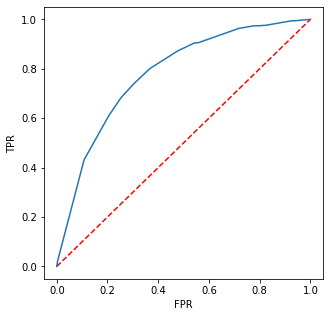

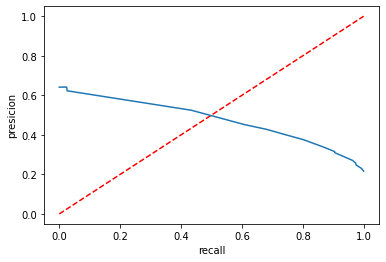

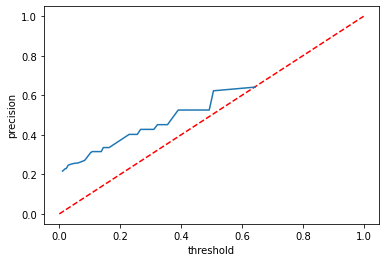

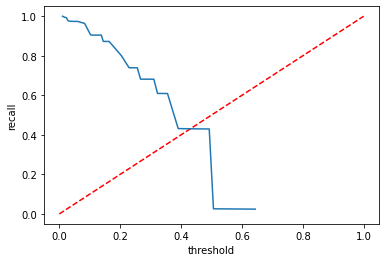

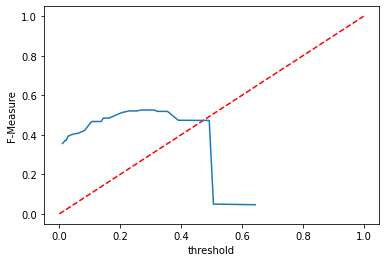

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.783
Area Under Precision-Recall Curve: 0.455

In [0]:
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))


plt.figure(figsize=(5,5))
# roc 
#plt.subplot(2, 6, 1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.roc.select('FPR').collect(),
         training_result.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#plt.subplot(2, 6, 2)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.pr.select('recall').collect(),
         training_result.pr.select('precision').collect())
plt.xlabel('recall')
plt.ylabel('presicion')
plt.show()

#plt.subplot(2, 6, 3)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.precisionByThreshold.select('threshold').collect(),
         training_result.precisionByThreshold.select('precision').collect())
plt.xlabel('threshold')
plt.ylabel('precision')
plt.show()


#plt.subplot(2, 6, 4)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.recallByThreshold.select('threshold').collect(),
         training_result.recallByThreshold.select('recall').collect())
plt.xlabel('threshold')
plt.ylabel('recall')
plt.show()

#plt.subplot(2, 6, 5)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(training_result.fMeasureByThreshold.select('threshold').collect(),
         training_result.fMeasureByThreshold.select('F-Measure').collect())
plt.xlabel('threshold')
plt.ylabel('F-Measure')


plt.show()

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

## Desicion Tree

In [0]:
# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform human/bot into 0/1) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the decision tree transformer
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [dt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for dt.maxDepth and 2 values for dt.impurity
    # this grid will have 3 x 2 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

### Train Set

In [0]:
cv_model = decision_tree_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# This function summarizes all the models trained during k-fold cross validation

def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDept=[{:d}]; impurity=[{:s}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getImpurity()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=9, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=51, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=45, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=283, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=265, numClasses=2, numFeatures=13

***************************************

*************** Fold #2 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=13, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=49, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=47, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=341, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=267, numClasses=2, numFeatures=13

***************************************

*************** Fold #3 ***************

--- Model #1 out of 6 ---
	Parameters: maxDept=[3]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=9, numClasses=2, numFeatures=13

--- Model #2 out of 6 ---
	Parameters: maxDept=[3]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=3, numNodes=11, numClasses=2, numFeatures=13

--- Model #3 out of 6 ---
	Parameters: maxDept=[5]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=43, numClasses=2, numFeatures=13

--- Model #4 out of 6 ---
	Parameters: maxDept=[5]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=5, numNodes=35, numClasses=2, numFeatures=13

--- Model #5 out of 6 ---
	Parameters: maxDept=[8]; impurity=[gini] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=293, numClasses=2, numFeatures=13

--- Model #6 out of 6 ---
	Parameters: maxDept=[8]; impurity=[entropy] 
	Model summary: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=2

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.256
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.253
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.493
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.403
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.498
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.510

In [0]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]; impurity=[{:s}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getImpurity(),
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[8]; impurity=[entropy]
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05e4e568d3ed, depth=8, numNodes=289, numClasses=2, numFeatures=13

In [0]:
# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
#training_result = cv_model.bestModel.stages[-1]

### Test Set

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(13,[0,3,5,7,8,12...| 1.0| 1.0|
[0.0,0.0,1.0,0.0,...| 0.0| 1.0|
(13,[0,5,6,7,8,11...| 0.0| 1.0|
(13,[0,3,5,8,11,1...| 1.0| 1.0|
[1.0,0.0,1.0,0.0,...| 0.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

### Evaluation

In [0]:
#print("***** Training Set *****")
#print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(training_result)))


print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.541
Area Under Precision-Recall Curve: 0.370

## Random Forests

In [0]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    # Configure a random forest pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform human/bot into 0/1) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for rf.maxDepth and 3 values for rf.numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model


In [0]:
cv_model = random_forest_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             )
      )
print(cv_model.bestModel.stages[-1])

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.836
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.854
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.858
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.874
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.882
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.883
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.903
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.908
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.909
Best model according to k-fold cross validation: maxDept=[8]
RandomForestClassificationModel: uid=RandomForestClassifier_87c38550a8f8, numTrees=100, numClasses=2, numFeatures=13

In [0]:
#training_result = cv_model.bestModel.stages[-1].summary
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

+--------------------+----------+-----+
 features|prediction|label|
+--------------------+----------+-----+
(13,[0,3,5,7,8,12...| 1.0| 1.0|
[0.0,0.0,1.0,0.0,...| 0.0| 1.0|
(13,[0,5,6,7,8,11...| 0.0| 1.0|
(13,[0,3,5,8,11,1...| 1.0| 1.0|
[1.0,0.0,1.0,0.0,...| 0.0| 1.0|
+--------------------+----------+-----+
only showing top 5 rows

In [0]:
#print("***** Training Set *****")
#print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(training_result)))


print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.908
Area Under Precision-Recall Curve: 0.812

## Gradient Boosted Decision Tree

In [0]:
# This function defines the general pipeline for logistic regression
def gbdt_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):

    # Configure a gradient boosted decision tree pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler] # + ...

    # Create the gradient boosted decision tree transformer
    gbdt = GBTClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the gradient boosted decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [gbdt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for gbdt.maxDepth and 3 values for gbdt.maxIter (i.e., boosting rounds)
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(gbdt.maxDepth, [3, 5, 8]) \
    .addGrid(gbdt.maxIter, [10, 50, 100]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = gbdt_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
print("Best model according to k-fold cross validation: maxDept=[{:d}]; maxIter=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getMaxIter()
             )
      )
print(cv_model.bestModel.stages[-1])

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(test_df)
test_predictions.select("features", "prediction", "label").show(5)

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

## Logistic Regression on textual features

## Clean text

In [0]:
def clean_text(text):

  if text is None:
    return None
  row = text.lower()
  row = row.strip() 
  row = re.sub(r'[^\w\s]',' ',row)

  
  filtered_sentence = []
  for w in row.split() :
    temp = porter.stem(w)
    filtered_sentence.append(temp)
  row = filtered_sentence
  
  return row
clean_udf = spark.udf.register("clean_text",clean_text)

In [0]:
def ml_pipeline(train):
    
    print("***** Defining the pipeline stages *****\n")
    
    # define stage 1: tokenize the tweet text  
    stage_1 = RegexTokenizer(inputCol="tweet_text", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)

    # define stage 4: tokenize the description
    stage_4 = RegexTokenizer(inputCol="description", outputCol="tokens_des", pattern="\\W")
    # define stage 2: remove the stop words
    stage_5 = StopWordsRemover(inputCol="tokens_des", outputCol="filtered_words_des")
    # define stage 3: create a word vector of the size 100
    stage_6 = Word2Vec(inputCol="filtered_words_des", outputCol="feature_vector_des", vectorSize=100)
   

    label_indexer = StringIndexer(inputCol = "account_type", outputCol = "label")
    
    # 4. Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=["feature_vector"]+["feature_vector_des"], outputCol="features")

    
    
    model = LogisticRegression(featuresCol="features", labelCol="label") 
    
    
    
    
    # 5. Populate the stages of the pipeline
    stages = [stage_1] + [stage_2] + [stage_3] + [stage_4] + [stage_5] + [stage_6] + [label_indexer] + [assembler] + [model]

    # 6. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=stages)

    # 7. Transform the input dataframe accordingly
    transformer = pipeline.fit(tweet_train_df)
    df_transformed = transformer.transform(tweet_train_df)
    
    
    
    
    return transformer, df_transformed

In [0]:
bot_df_text = bot_df_text.select(clean_udf(col("tweet_text")) , clean_udf(col("description")),"account_type")
tweet_train_df, tweet_test_df = bot_df_text.randomSplit([0.8, 0.2], seed=RANDOM_SEED)
tweet_train_df = tweet_train_df.na.drop()

In [0]:
tweet_train_df = tweet_train_df.withColumnRenamed("clean_text(tweet_text)", "tweet_text")\
       .withColumnRenamed("clean_text(description)", "description")

In [0]:
# Fit the ML pipeline to the training set of tweets
oh_transformer, oh_train_df = ml_pipeline(tweet_train_df)
tweet_train_df.show(100)

In [0]:
train = oh_train_df.select(["features", "label"])
log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)
log_reg_model = log_reg.fit(train)
print("Intercept: {:.5f}".format(log_reg_model.intercept))
print("{:d} Coefficients: [{:s}]".format(len(log_reg_model.coefficients), ",".join(["{:.3f}".format(c) for c in log_reg_model.coefficients])))

In [0]:
theta = np.sort(log_reg_model.coefficients)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=range(0,len(log_reg_model.coefficients)), y=theta, marker="o", axes=ax)
_ = ax.set_xlabel("Theta Index", labelpad=20)
_ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)


In [0]:
training_summary = log_reg_model.summary
precision_recall = training_summary.pr.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=precision_recall['recall'], y=precision_recall['precision'], marker="s", axes=ax)
_ = ax.set_xlabel("Recall", labelpad=20)
_ = ax.set_ylabel("Precision", labelpad=20)
_ = ax.set_title("Precision vs. Recall")


In [0]:
roc = training_summary.roc.toPandas()

fig, ax = plt.subplots(1, 1, figsize=(8,6))
_ = sns.lineplot(x=roc['FPR'], y=roc['TPR'], marker="s", axes=ax)
_ = ax.set_xlabel("False Positive Rate", labelpad=20)
_ = ax.set_ylabel("True Positive Rate", labelpad=20)
_ = ax.set_title("ROC Curve")

In [0]:
# Print out the Area Under the ROC Curve (AUC)
print('Training Set AUC: {:.3f}'.format(training_summary.areaUnderROC))
tweet_test_df = tweet_test_df.withColumnRenamed("clean_text(tweet_text)", "tweet_text")\
       .withColumnRenamed("clean_text(description)", "description")

oh_test_df = oh_transformer.transform(tweet_test_df)
test = oh_test_df.select(["features", "label"])
predictions = log_reg_model.transform(test)

evaluator = BinaryClassificationEvaluator()
print('Test Set AUC: {:.3f}'.format(evaluator.evaluate(predictions)))


## Tuning hyperparameters

In [0]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train, 
                                 target_variable, 
                                 with_std=True,
                                 with_mean=True,
                                 k_fold=5):

    # Configure a logistic regression pipeline, which consists of the following stages: 
    # 1) convert categorical features to numerical ones
    # 2) standardize feature values (optional)
    # ... add any other custom transformation here ...
    # n) fit a logistic regression model

    stage_1 = RegexTokenizer(inputCol="tweet_text", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)

    # define stage 4: tokenize the description
    stage_4 = RegexTokenizer(inputCol="description", outputCol="tokens_des", pattern="\\W")
    # define stage 2: remove the stop words
    stage_5 = StopWordsRemover(inputCol="tokens_des", outputCol="filtered_words_des")
    # define stage 3: create a word vector of the size 100
    stage_6 = Word2Vec(inputCol="filtered_words_des", outputCol="feature_vector_des", vectorSize=100)
   

   

    # 1.c Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=["feature_vector"]+["feature_vector_des"] , outputCol="features")

    # 2.a Create the StandardScaler
    # scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = [stage_1] + [stage_2] + [stage_3] + [stage_4] + [stage_5] + [stage_6] + [label_indexer] + [assembler]  # + [scaler] + ...

    # 4. Create the logistic regression transformer
    log_reg = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100) # change `featuresCol=std_features` if scaler is used
    # 5. Add the logistic regression transformer to the pipeline stages (i.e., the last one)
    stages += [log_reg]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for log_reg.regParam ($\lambda$) and 3 values for log_reg.elasticNetParam ($\alpha$),
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(log_reg.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = logistic_regression_pipeline(tweet_train_df, TARGET_VARIABLE)

In [0]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [0]:
# Call the function above|
summarize_all_models(cv_model.subModels)

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))


In [0]:

print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getRegParam(), 
             cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam(),
             )
      )
print(cv_model.bestModel.stages[-1])

In [0]:

# `bestModel` is the best resulting model according to k-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1].summary
print("***** Training Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(training_result.areaUnderROC))
print("***** Training Set *****")


In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(tweet_test_df)

test_predictions.select("features", "prediction", "label").show(5)

def evaluate_model(predictions, metric="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(metricName=metric)
    return evaluator.evaluate(predictions)

print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

## Decision Tree

In [0]:


# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    stage_1 = RegexTokenizer(inputCol="tweet_text", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)

    # define stage 4: tokenize the description
    stage_4 = RegexTokenizer(inputCol="description", outputCol="tokens_des", pattern="\\W")
    # define stage 2: remove the stop words
    stage_5 = StopWordsRemover(inputCol="tokens_des", outputCol="filtered_words_des")
    # define stage 3: create a word vector of the size 100
    stage_6 = Word2Vec(inputCol="filtered_words_des", outputCol="feature_vector_des", vectorSize=100)


    # 1.c Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=["feature_vector"]+["feature_vector_des"] , outputCol="features")

    # 2.a Create the StandardScaler
    # scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = [stage_1] + [stage_2] + [stage_3] + [stage_4] + [stage_5] + [stage_6] + [label_indexer] + [assembler]  # + [scaler] + ...

    # Create the decision tree transformer
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the decision tree transformer to the pipeline stages (i.e., the last one)
    stages += [dt]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for dt.maxDepth and 2 values for dt.impurity
    # this grid will have 3 x 2 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = decision_tree_pipeline(tweet_train_df, TARGET_VARIABLE)


In [0]:
c# This function summarizes all the models trained during k-fold cross validation

def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDept=[{:d}]; impurity=[{:s}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getImpurity()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***********************

In [0]:
summarize_all_models(cv_model.subModels)

In [0]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

print("Best model according to k-fold cross validation: maxDept=[{:d}]; impurity=[{:s}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             cv_model.bestModel.stages[-1]._java_obj.getImpurity(),
             )
      )
print(cv_model.bestModel.stages[-1])

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(tweet_test_df)
test_predictions.select("features", "prediction", "label").show(5)
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

## Random Forests

In [0]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):


    # Configure a random forest pipeline, which consists of the following stages: 

    stage_1 = RegexTokenizer(inputCol="tweet_text", outputCol="tokens", pattern="\\W")
    # define stage 2: remove the stop words
    stage_2 = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
    # define stage 3: create a word vector of the size 100
    stage_3 = Word2Vec(inputCol="filtered_words", outputCol="feature_vector", vectorSize=100)

    # define stage 4: tokenize the description
    stage_4 = RegexTokenizer(inputCol="description", outputCol="tokens_des", pattern="\\W")
    # define stage 2: remove the stop words
    stage_5 = StopWordsRemover(inputCol="tokens_des", outputCol="filtered_words_des")
    # define stage 3: create a word vector of the size 100
    stage_6 = Word2Vec(inputCol="filtered_words_des", outputCol="feature_vector_des", vectorSize=100)
   

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label, which in the case of `deposit` is `no`
    # As such, this nicely resembles the idea of having `deposit = 0` if no deposit is subscribed, or `deposit = 1` otherwise.
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # 1.d Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=["feature_vector"]+["feature_vector_des"] , outputCol="features")

    # 2.a Create the StandardScaler
    # scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_"+assembler.getOutputCol(), withStd=with_std, withMean=with_mean)
    # ...

    # 3 Populate the stages of the pipeline with all the preprocessing steps
    stages = [stage_1] + [stage_2] + [stage_3] + [stage_4] + [stage_5] + [stage_6] + [label_indexer] + [assembler]  # + [scaler] + ...

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label") # change `featuresCol=std_features` if scaler is used

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for rf.maxDepth and 3 values for rf.numTrees
    # this grid will have 3 x 3 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [0]:
cv_model = random_forest_pipeline(tweet_train_df, TARGET_VARIABLE)
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             )
      )
print(cv_model.bestModel.stages[-1])

In [0]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_predictions = cv_model.transform(tweet_test_df)
test_predictions.select("features", "prediction", "label").show(5)

In [0]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")